## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [1]:
%load_ext autoreload
%autoreload 2


#### Basic imports:

In [2]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import anndata

import ssam

#### Define parameters

In [3]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [4]:

if dataset == 0:

    # adata = anndata.read_h5ad(os.path.join(file_root,'../../data/z-incoherence/counts_WS_blur5_exp0.h5ad'))

    # coords_louis = adata.uns['spots'].copy()

    adata = anndata.read_h5ad(os.path.join(file_root,'../../data/z-incoherence/ms_brain_rep2.h5ad'),)

    coords = adata.uns['spots'].copy()

    coords = coords[~(coords.feature_name.str.contains("BLANK") | coords.feature_name.str.contains("NegControl"))]

    # coords['cell_id_louis'] = coords_louis['cell'].to_numpy()
    # coords['cell_type_louis'] = list(coords_louis['celltype'])

    # del adata, coords_louis
#     adata = anndata.read_h5ad('../../data/z-incoherence/reads_to_ref_scRNAseq_cluster_sample2.csv')

    spot_df_raw = coords[['x_location' ,'y_location' ,'z_location','feature_name' ]]#,'cell_id','cell_type_louis','cell_id_louis']]

    # replace the feature_name Ccn2 with Ctgf, which is present in the scRNAseq data:
    spot_df_raw.loc[spot_df_raw.feature_name=='Ccn2','feature_name'] = 'Ctgf'

    # spot_df_raw=spot_df_raw[['global_x','global_y','global_z','gene']]
    spot_df_raw.columns = ['x','y','z','gene' ,]#'cell_id','cell_type_louis','cell_id_louis']

    # x_,_x,y_,_y = 1000,9000,1000,9000
    # spatial_mask =  (spot_df_raw.x>x_)&(spot_df_raw.x<_x)&\
    #                 (spot_df_raw.y>x_)&(spot_df_raw.y<_y)

    # spot_df_raw = spot_df_raw[spatial_mask]

    # Remove 'blank' genes:
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]

    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


del coords,
spot_df_raw


,x,y,z,gene
transcript_id,,,,
281496451547136,108.882760,1191.4623,15.111133,Dkk3
281496451547137,599.608800,1214.9828,13.810570,Neurod6
281496451547138,40.342777,1966.5145,14.667373,Ipcef1
281496451547139,34.722248,2017.1637,15.058671,Bhlhe40
281496451547140,623.589000,1048.9484,15.842804,Car4
...,...,...,...,...
281513631904696,2738.748300,1722.5444,28.736680,Cdh13
281513631904697,2618.527000,1743.7420,29.148848,Fign
281513631904698,2907.959700,1812.5348,28.413157,Zfp536


In [57]:
spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel

In [58]:
rois_x,rois_y, divergence_score = ovrlp.find_overlaps(coordinate_df=spot_df_raw,)

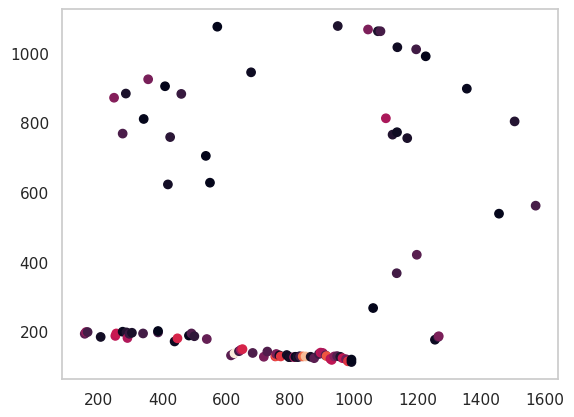

In [59]:
plt.scatter(rois_x,rois_y,c=magnitude)

In [6]:
from src import ovrlp

_=ovrlp.assign_xy(spot_df_raw)

In [41]:
# median = ovrlp.assign_z_median(bspot_df_raw)
mean = ovrlp.assign_z_mean(spot_df_raw)


108.99924494765203 54.499622473826015


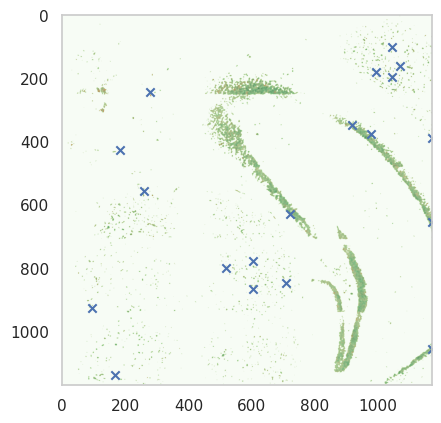

In [42]:

KDE_bandwidth = 1.5
min_expression = 15
min_distance = 40
threshold_fraction = 0.5

rois_x,rois_y,divergence_score = ovrlp.compute_divergence(spot_df_raw, genes=genes, 
                                                     KDE_bandwidth=KDE_bandwidth, threshold_fraction=threshold_fraction, 
                                                     min_distance = min_distance, min_expression=min_expression, plot=True)

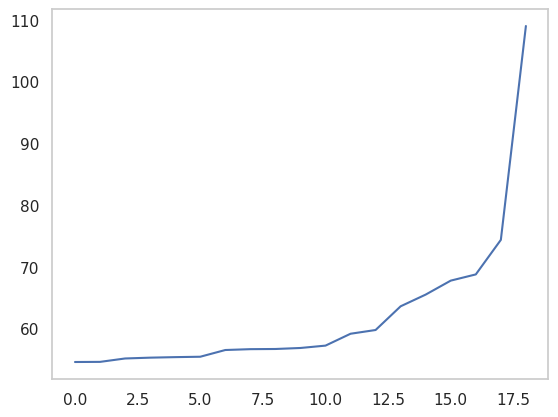

In [43]:
plt.plot(sorted(divergence_score))

233
242
248
251
214
204
249
241
258
285
223
224
224
252
259
276
218
220


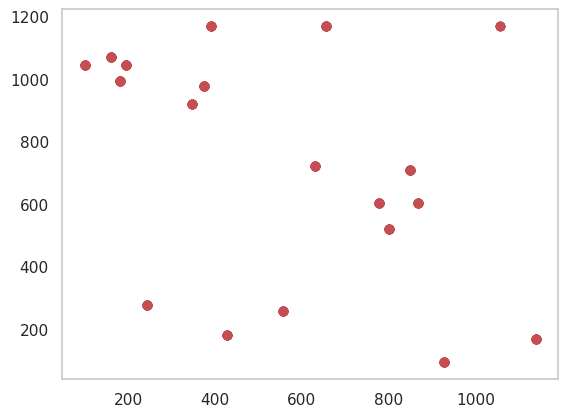

In [44]:

expressions_top, expressions_bottom = ovrlp.get_expression_vectors_at_rois(spot_df_raw,rois_x,rois_y,genes)
expressions = np.stack([expressions_top,expressions_bottom])

# plt.plot(sorted(expressions.sum(-1).sum(0)))


In [11]:
import time
from  tqdm.notebook import tqdm
from scipy.signal import fftconvolve

hists_top = np.zeros((spot_df_raw.x_pixel.max()+1,spot_df_raw.y_pixel.max()+1,len(genes)))
hists_bottom = np.zeros((spot_df_raw.x_pixel.max()+1,spot_df_raw.y_pixel.max()+1,len(genes)))

starting_time = time.perf_counter()


def create_circular_kernel(kernel_width):
    span = np.linspace(-1,1,kernel_width)
    X,Y = np.meshgrid(span,span)
    return (X**2+Y**2)**0.5<=1

kernel_width = 2

circular_kernel = create_circular_kernel(kernel_width)

if kernel_width<3:
    circular_kernel[:]=1

hist_bins = [np.arange(hists_top.shape[0]+1),np.arange(hists_top.shape[1]+1)]

for i,g in (t_bar := tqdm(enumerate(genes),total=len(genes))):

    t_bar.set_description(g)
    subsample = spot_df_raw[spot_df_raw.gene==g]

    subsample_top = subsample[subsample.z>=subsample.z_delim]
    hist_top,_,_ = np.histogram2d(subsample_top.x_pixel,subsample_top.y_pixel,bins=hist_bins)

    subsample_bottom = subsample[subsample.z<=subsample.z_delim]
    hist_bottom,_,_ = np.histogram2d(subsample_bottom.x_pixel,subsample_bottom.y_pixel,bins=hist_bins)

    hists_top[:,:,i] = fftconvolve(hist_top,circular_kernel,mode='same')
    hists_bottom[:,:,i] = fftconvolve(hist_bottom,circular_kernel,mode='same')

hists_top = np.round(np.log(hists_top+1)).astype(int)
hists_bottom = np.round(np.log(hists_bottom+1)).astype(int)

del hist_top, hist_bottom

# cosine_similarity = (hists_top / (hists_top**2).sum(-1,keepdims=True)**0.5 * hists_bottom/(hists_bottom**2).sum(-1,keepdims=True)**0.5).sum(-1)



  0%|          | 0/284 [00:00<?, ?it/s]

/tmp/ipykernel_1102924/3246817181.py:44: RuntimeWarning: invalid value encountered in true_divide
  cosine_similarity = (hists_top / (hists_top**2).sum(-1,keepdims=True)**0.5 * hists_bottom/(hists_bottom**2).sum(-1,keepdims=True)**0.5).sum(-1)


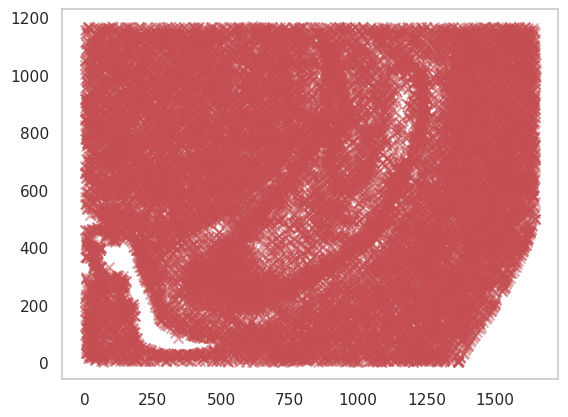

In [12]:
# A quick re-implementation of the SSAM-algorithm to determine celltypes:
# detect local maxima in the aggregated top and bottom counts:

from scipy import ndimage

local_max_radius = 10
local_max_footprint = create_circular_kernel(local_max_radius)

local_median_radius = 30
local_median_footprint = create_circular_kernel(local_median_radius)

aggregated_signal = hists_bottom.sum(-1)+hists_top.sum(-1)
aggregated_signal = ndimage.gaussian_filter(aggregated_signal, sigma=1)
max_filtered_signal = ndimage.maximum_filter(aggregated_signal, footprint=local_max_footprint, )
median_filtered_signal = ndimage.median_filter(aggregated_signal, footprint=local_median_footprint, )

min_cells = 10

localmaxs_celltyping = np.array(np.where((max_filtered_signal==aggregated_signal)&
                                         ((median_filtered_signal*0)<aggregated_signal) & 
                                         (median_filtered_signal>0)&(hists_top.sum(-1)>min_cells)&(hists_bottom.sum(-1)>min_cells))).T

# gene expression vector samples at the detected local maxima:
localmax_celltyping_samples = np.concatenate([hists_top[localmaxs_celltyping[:,0],localmaxs_celltyping[:,1],:],
                                              hists_bottom[localmaxs_celltyping[:,0],localmaxs_celltyping[:,1],:]],0)
localmax_celltyping_samples = localmax_celltyping_samples/(localmax_celltyping_samples**2).sum(1,keepdims=True)**0.5

# del aggregated_signal,median_filtered_signal,max_filtered_signal

plt.scatter(localmaxs_celltyping[:,1],localmaxs_celltyping[:,0],c='r',marker='x',alpha=0.5,s=50)


In [13]:
from sklearn.decomposition import PCA as Dimred


def fill_color_axes(rgb,dimred=None):

    if dimred is None:
        dimred = Dimred(n_components=3)
        dimred.fit(rgb)

    facs = dimred.transform(rgb)

    # rotate the ica_facs 45 in all the dimensions:
    # define a 45-degree 3d rotation matrix 
    # (0.500 | 0.500 | -0.707
    # -0.146 | 0.854 | 0.500
    # 0.854 | -0.146 | 0.500)
    rotation_matrix = np.array([[0.500,0.500,-0.707],
                                [-0.146,0.854,0.500],
                                [0.854,-0.146,0.500]])

    # rotate the facs:
    facs = np.dot(facs,rotation_matrix)


    return facs,dimred


# create circular kernel:
def create_circular_kernel(kernel_width):
    span = np.linspace(-1,1,kernel_width)
    X,Y = np.meshgrid(span,span)
    return (X**2+Y**2)**0.5<=1


# normalize array:
def min_to_max(arr):
    arr=arr-arr.min(0,keepdims=True)
    arr/=arr.max(0,keepdims=True)
    return arr

# convert cymk to rgb:
def cymk_to_rgb(cymk):
    c,y,m,k = cymk.T
    r = (1-c)*(1-k)
    g = (1-m)*(1-k)
    b = (1-y)*(1-k)
    return np.array([r,g,b]).T

def haversine_to_rgb(embedding):
    r = np.cos(embedding[:,0])*np.sin(embedding[:,1])
    g = np.sin(embedding[:,0])*np.sin(embedding[:,1])
    b = np.cos(embedding[:,1])
    return np.array([r,g,b]).T

def visualize_rgb_scale(rgb):
    fig = plt.figure(figsize=(15,7))

    ax1 = fig.add_subplot(121)
    ax1.scatter(embeddings_2d[:,0],embeddings_2d[:,1],c=rgb,alpha=0.5)
    plot_label_coords()

    ax2 = fig.add_subplot(122,projection='3d')
    ax2.scatter(rgb[:,0],rgb[:,1],rgb[:,2],c=rgb,alpha=0.5)

    plt.tight_layout()



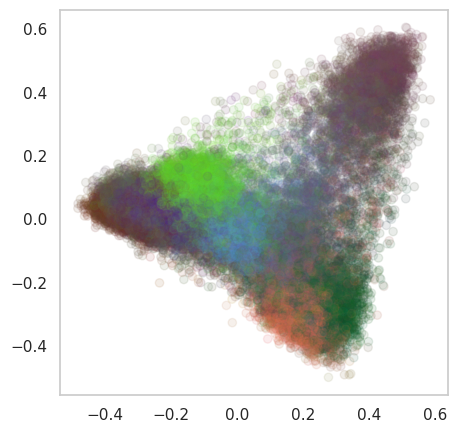

In [14]:
from sklearn.decomposition import PCA as dim_reduction

pca = dim_reduction(n_components=100)
factors = pca.fit_transform(localmax_celltyping_samples)

colors = min_to_max(factors[:,2:5])

plt.figure(figsize=(5,5))

plt.scatter(factors[:,0],factors[:,1],c=colors,alpha=0.1)


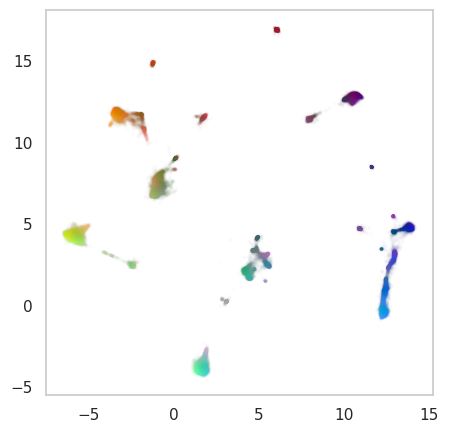

In [15]:
import umap

embedder_2d = umap.UMAP(n_components=2,min_dist=0.0)
embedding = embedder_2d.fit_transform(factors)

embedder_3d = umap.UMAP(n_components=3, min_dist=0.0,n_neighbors=10,
                  init=np.concatenate([embedding,0.1*np.random.normal(size=(embedding.shape[0],1))],axis=1))
embedding_color = embedder_3d.fit_transform(embedding)

embedding_color,color_pca = fill_color_axes(embedding_color)


color_min = embedding_color.min(0)
color_max = embedding_color.max(0)

colors = min_to_max(embedding_color.copy())

plt.figure(figsize=(5,5))
plt.scatter(embedding[:,0],embedding[:,1],c=colors,alpha=0.01,s=3)

#### Load snRNAseq data for cell typing:

In [16]:
# We assign each spot to the nearest celltype, using an annotated single-cell dataset:

# Load the single-cell dataset:
adata_snrna = anndata.read_h5ad('../../data/z-incoherence/counts_CPn_exp0.h5ad')
adata_snrna = adata_snrna[:,adata_snrna.var.index.isin(genes)]
adata_snrna.obs = adata_snrna.obs[['celltype']]

# Load the single-cell dataset:
adata_scrna = anndata.read_h5ad('../../data/z-incoherence/counts_WS_blur5_exp0.h5ad')
adata_scrna = adata_scrna[:,adata_scrna.var.index.isin(genes)]
adata_scrna.obs = adata_scrna.obs[['celltype']]

adata_sncrna = anndata.concat([adata_snrna,adata_scrna],axis=0,join='outer')
adata_sncrna.obs['celltype_coarse'] = adata_sncrna.obs.celltype.apply(lambda x: x.split(' ')[0])

adata_sncrna.obs.index = ('Cell_'+pd.Series(np.arange(adata_sncrna.shape[0])).astype(str)).values

del adata_snrna,adata_scrna

# define a signature matrix of mean celltype expression profiles:
celltypes = sorted(adata_sncrna.obs.celltype_coarse.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_sncrna.X[adata_sncrna.obs.celltype_coarse==celltype,:]
    subset = pd.Series(np.nan_to_num(subset).mean(0),
                       index=adata_sncrna.var.index)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("ob

#### create signature matrix:

#### assign celltypes to localmax samples:

In [17]:
# determine correlation of each localmax sample with the signatures:

def determine_celltype_class_assignments(expression_samples):
    correlations = np.array([np.corrcoef(expression_samples[i,:],signatures.values.T)[0,1:] for i in range(len(expression_samples))])
    return np.argmax(correlations,-1)

celltype_class_assignments = determine_celltype_class_assignments(localmax_celltyping_samples)

# determine the center of gravity of each celltype in the embedding:
celltype_centers = np.array([np.median(embedding[celltype_class_assignments==i,:],axis=0) for i in range(len(celltypes))])

#### plotting helper functions:

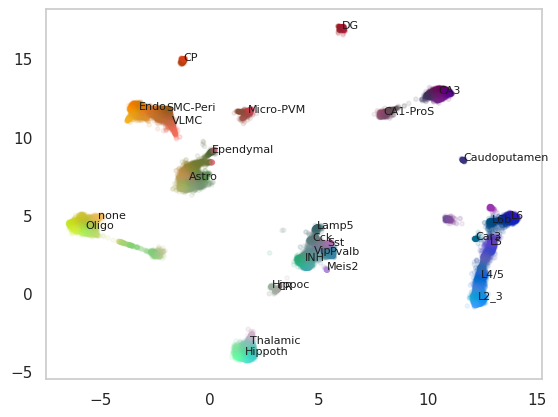

In [18]:
# define a function that fits expression data to into the umap embeddings:

def transform_embeddings(expression,pca):

    factors = pca.transform(expression)

    embedding = embedder_2d.transform(factors)
    embedding_color = embedder_3d.transform(embedding)
    
    # embedding_color = (embedding_color-color_min)/(color_max-color_min)
    
    return embedding, embedding_color

# define a function that plots the embeddings, with celltype centers rendered as plt.texts on top:
def plot_embeddings(embedding,embedding_color):
    colors = np.clip(embedding_color.copy(),0,1)

    plt.scatter(embedding[:,0],embedding[:,1],c=(colors),alpha=0.1,marker='.')
    for i in range(len(celltypes)):
        plt.text(celltype_centers[i,0],celltype_centers[i,1],celltypes[i],color='k',fontsize=8)


# plot embeddings, with celltype centers rendered as plt.texts on top:
plot_embeddings(embedding,colors)

In [19]:
from sklearn.neighbors import NearestNeighbors

# define a function that subsamples spots around x,y given a window size:
def get_spatial_subsample_mask(x,y,window_size=5):
    return (spot_df_raw.x>x-window_size)&(spot_df_raw.x<x+window_size)&(spot_df_raw.y>y-window_size)&(spot_df_raw.y<y+window_size)

# define a function that returns the k nearest neighbors of x,y:
def create_knn_graph(coords,k=10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    return distances, indices

# get a kernel-weighted average of the expression values of the k nearest neighbors of x,y:
def get_knn_expression(distances,neighbor_indices,gene_labels,bandwidth=2.5):

    weights = np.exp(-distances/bandwidth)
    local_expression = pd.DataFrame(index = genes, columns = np.arange(distances.shape[0])).astype(float)

    for i,gene in enumerate(genes):
        weights_ = weights.copy()
        weights_[(gene_labels[neighbor_indices])!=i] = 0
        local_expression.loc[gene,:] = weights_.sum(1)
    
    return local_expression

def pixelmap_to_raw(x,y):
    shift_x = int((spot_df_raw.x/um_per_pixel).min())
    shift_y = int((spot_df_raw.y/um_per_pixel).min())
    return (x+shift_x)*um_per_pixel,(y+shift_y)*um_per_pixel

def raw_to_pixelmap(x,y):
    x = ((spot_df_raw.x/um_per_pixel).astype(int))
    y = ((spot_df_raw.y/um_per_pixel).astype(int))

    return (x/um_per_pixel-x.min()),(y/um_per_pixel-y.min())

def get_celltype(expression_vector):
    return celltypes[np.argmax(np.corrcoef(expression_vector,signatures.values.T)[0,1:])]


In [45]:
# plot a case of z-incoherence:

# sorted_correlations = correlation.argsort()
idcs = divergence_score.argsort()[::-1] #sorted_correlations.values[[0]]

combinations = []
for n_case in range(len(idcs)):        
    x,y = (rois_x[idcs[n_case]],rois_y[idcs[n_case]])
    ct_1 = get_celltype(expressions_top.iloc[idcs[n_case]])
    ct_2 = get_celltype(expressions_bottom.iloc[idcs[n_case]])

    combinations.append(sorted([ct_1,ct_2]))


combinations

[['Ependymal', 'Pvalb'],
 ['CA3', 'Caudoputamen'],
 ['Endo', 'SMC-Peri'],
 ['L5', 'L6'],
 ['Car3', 'Lamp5'],
 ['L5', 'L6b'],
 ['CA3', 'Pvalb'],
 ['Hippoth', 'L4/5'],
 ['Endo', 'L2_3'],
 ['Endo', 'Ependymal'],
 ['CR', 'Vip'],
 ['VLMC', 'VLMC'],
 ['CA1-ProS', 'Hippoth'],
 ['Oligo', 'none'],
 ['INH', 'Oligo'],
 ['CA1-ProS', 'none'],
 ['CA1-ProS', 'CA1-ProS'],
 ['Ependymal', 'SMC-Peri'],
 ['CA1-ProS', 'CA1-ProS']]

In [46]:
# [print(c) for c in combinations[:15]]
# [print(c) for c in combinations[-15::][::-1]]

<AxesSubplot: >

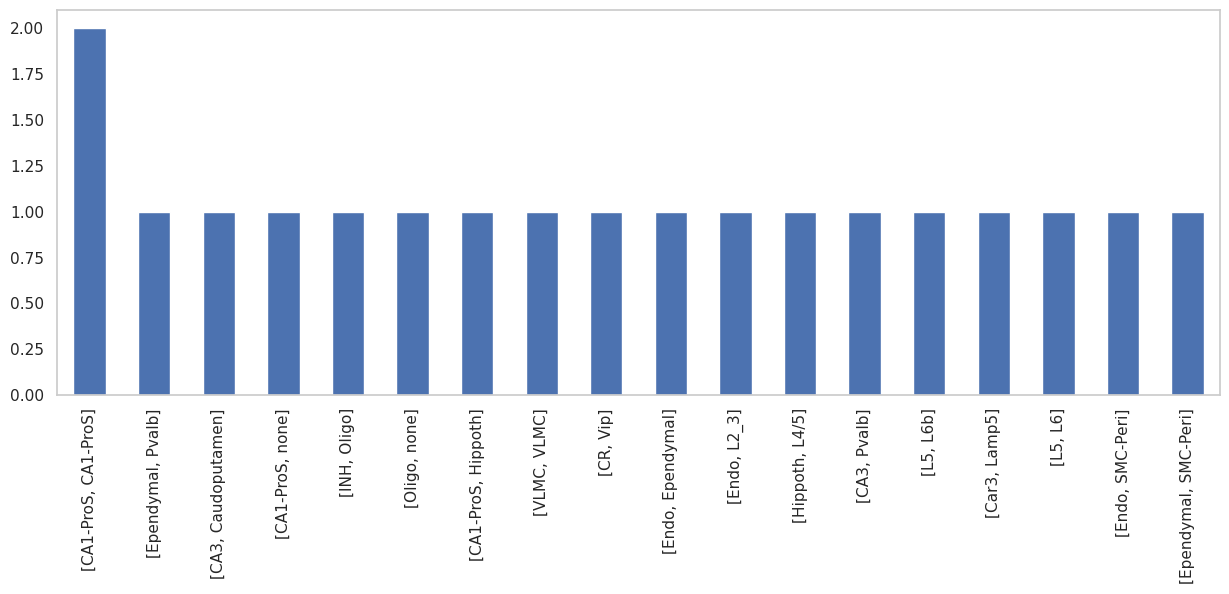

In [47]:
plt.figure(figsize=(15,5))
pd.Series(combinations).value_counts()[:70].plot.bar()

In [49]:
# plot a case of z-incoherence:

# sorted_correlations = correlation.argsort()
correlation = np.array(divergence_score)
idcs = correlation.argsort()[::-1] #sorted_correlations.values[[0]]


def plot_z_incoherence(n_case,window_size = 40):
        
    x,y = (rois_x[idcs[n_case]],rois_y[idcs[n_case]])

    # ct_top,ct_bottom = get_celltype(expressions_top.iloc[idcs[n_case]]),get_celltype(expressions_bottom.iloc[idcs[n_case]])

    subsample_mask = get_spatial_subsample_mask(x,y,window_size=window_size)
    subsample = spot_df_raw[subsample_mask]

    distances, neighbor_indices = create_knn_graph(subsample[['x','y','z']].values,k=90)
    local_expression = get_knn_expression(distances,neighbor_indices,subsample.gene.cat.codes.values,bandwidth=1.0)
    local_expression = local_expression/((local_expression**2).sum(0)**0.5)
    subsample_embedding, subsample_embedding_color = transform_embeddings(local_expression.T.values,pca)
    subsample_embedding_color,_ = fill_color_axes(subsample_embedding_color,color_pca)
    subsample_embedding_color = (subsample_embedding_color-color_min)/(color_max-color_min)
    subsample_embedding_color = np.clip(subsample_embedding_color,0,1)

    plt.figure(figsize=(18,12))

    # plt.suptitle('-'.join([str(ct_top),str(ct_bottom)]))

    ax1 = plt.subplot(234,projection='3d')
    ax1.scatter(subsample.x,subsample.y,subsample.z,c=subsample_embedding_color,marker='.',alpha=0.1)
    ax1.set_zlim(np.median(subsample.z)-window_size,np.median(subsample.z)+window_size)

    ax2 = plt.subplot(231)
    plt.scatter(embedding[:,0],embedding[:,1],c='lightgrey',alpha=0.05,marker='.')
    plot_embeddings(subsample_embedding,subsample_embedding_color)
    # plt.scatter(subsample_embedding[:,0],subsample_embedding[:,1],c=subsample_embedding_color,marker='.',alpha=0.1,s=10)

    # ax3 = plt.subplot(235)
    # central_cutout = subsample[(subsample.x<x+5)&(subsample.x>x-5)]
    # ax3.scatter(central_cutout.y,central_cutout.z,c=subsample_embedding_color[(subsample.x<x+5)&(subsample.x>x-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    # ax3 = plt.subplot(236)
    # central_cutout = subsample[(subsample.y<y+5)&(subsample.y>y-5)]
    # ax3.scatter(central_cutout.x,central_cutout.z,c=subsample_embedding_color[(subsample.y<y+5)&(subsample.y>y-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)
    
    ax3 = plt.subplot(235)
    # plt.imshow((divergence*hist_sum).T,cmap='Greys', alpha=0.3 )
    ax3.scatter(subsample[subsample.z>subsample.z_delim].x,subsample[subsample.z>subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z>subsample.z_delim],marker='.',alpha=0.1,s=20)
    ax3.set_xlim(x-window_size,x+window_size)
    ax3.set_ylim(y-window_size,y+window_size)

    ax3 = plt.subplot(236)    
    # plt.imshow(hist_sum.T,cmap='Greys',alpha=0.3 )
    ax3.scatter(subsample[subsample.z<subsample.z_delim].x,subsample[subsample.z<subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z<subsample.z_delim],marker='.',alpha=0.1,s=20)
    ax3.set_xlim(x-window_size,x+window_size)
    ax3.set_ylim(y-window_size,y+window_size)
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    # ax3 = plt.subplot(236)
    # central_cutout = subsample[(subsample.y<y+5)&(subsample.y>y-5)]
    # ax3.scatter(central_cutout.x,central_cutout.z,c=subsample_embedding_color[(subsample.y<y+5)&(subsample.y>y-5)])
    # ax3.set_ylim(np.median(subsample.z)-window_size/2,np.median(subsample.z)+window_size/2)

    ax4 = plt.subplot(232)
    plt.scatter(spot_df_raw.x,spot_df_raw.y,c='k',alpha=0.01,marker='.',s=1)
    plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=1)

    # ax5 = plt.subplot(233)
    # s_expression = pd.Series(expressions_top.iloc[idcs[n_case]]-expressions_bottom.iloc[idcs[n_case]],index=genes)
    # idcs_ = (s_expression**2).argsort()[:-20:-1]
    # expressions_top.iloc[idcs[n_case]].iloc[idcs_].plot.bar()
    # (-expressions_bottom).iloc[idcs[n_case]].iloc[idcs_].plot.bar(color='r')


    # ax4 = plt.subplot(224)
    # plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=20)


for i in range(10):
    plot_z_incoherence(i)